# Batch Normalization(Dropout Effect)

这里我们来体现一下BN的具有轻微的Dropout效果

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from miniBatch import random_mini_batche  
from data_utils import get_CIFAR10_data
from tensorflow.python.framework import ops
import os

In [2]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [35]:
def load_data(index_train,index_val,index_test):
    train_x = data['X_train'][:index_train].reshape(index_train,-1)
    train_y = data['y_train'][:index_train]
    
    val_x = data['X_val'][:index_val].reshape(index_val,-1)
    val_y = data['y_val'][:index_val]
    
    test_x = data['X_test'][:index_test].reshape(index_test,-1)
    test_y = data['y_test'][:index_test]
    
    return train_x,train_y,val_x,val_y,test_x,test_y

In [36]:
train_x,train_y,val_x,val_y,test_x,test_y = load_data(2000,100,100)

In [37]:
def init_parameters(n,mode):
    cache = []
    if mode == "BL":
        W1 = tf.get_variable('W1',[n,100],initializer=tf.contrib.layers.xavier_initializer(seed=0))
        b1 = tf.get_variable('b1',[1,100],initializer=tf.zeros_initializer())
        W2 = tf.get_variable('W2',[100,80],initializer=tf.contrib.layers.xavier_initializer(seed=1))
        b2 = tf.get_variable('b2',[1,80],initializer=tf.zeros_initializer())
        W3 = tf.get_variable('W3',[80,50],initializer=tf.contrib.layers.xavier_initializer(seed=3))
        b3 = tf.get_variable('b3',[1,50],initializer=tf.zeros_initializer())
        W4 = tf.get_variable('W4',[50,30],initializer=tf.contrib.layers.xavier_initializer(seed=4))
        b4 = tf.get_variable('b4',[1,30],initializer=tf.zeros_initializer())
        W5 = tf.get_variable('W5',[30,10],initializer=tf.contrib.layers.xavier_initializer(seed=5))
        b5 = tf.get_variable('b5',[1,10],initializer=tf.zeros_initializer())
        cache.append(W1)
        cache.append(b1)
        cache.append(W2)
        cache.append(b2)
        cache.append(W3)
        cache.append(b3)
        cache.append(W4)
        cache.append(b4)
        cache.append(W5)
        cache.append(b5)
        return cache
    else:
        W1 = tf.get_variable('W1',[n,100],initializer=tf.contrib.layers.xavier_initializer(seed=0))
        W2 = tf.get_variable('W2',[100,80],initializer=tf.contrib.layers.xavier_initializer(seed=1))
        W3 = tf.get_variable('W3',[80,50],initializer=tf.contrib.layers.xavier_initializer(seed=3))
        W4 = tf.get_variable('W4',[50,30],initializer=tf.contrib.layers.xavier_initializer(seed=4))
        W5 = tf.get_variable('W5',[30,10],initializer=tf.contrib.layers.xavier_initializer(seed=5))
        cache.append(W1)
        cache.append(W2)
        cache.append(W3)
        cache.append(W4)
        cache.append(W5)
        return cache

In [44]:
def forward(X,cache,mode,is_training=None):
    
    if mode=="BL":
        W1,b1,W2,b2,W3,b3,W4,b4,W5,b5 = cache

        Z1 = tf.add(tf.matmul(X,W1),b1)
        A1 = tf.nn.relu(Z1)
        Z2 = tf.add(tf.matmul(A1,W2),b2)
        A2 = tf.nn.relu(Z2)
        Z3 = tf.add(tf.matmul(A2,W3),b3)
        A3 = tf.nn.relu(Z3)
        Z4 = tf.add(tf.matmul(A3,W4),b4)
        A4 = tf.nn.relu(Z4)
        Z5 = tf.add(tf.matmul(A4,W5),b5)
        return Z5
    
    else:
        W1,W2,W3,W4,W5 = cache
        
        Z1 = tf.matmul(X,W1)
        Z1_norm = tf.layers.batch_normalization(Z1,axis=1,training=is_training)
        A1 = tf.nn.relu(Z1_norm)
        Z2 = tf.matmul(A1,W2)
        Z2_norm = tf.layers.batch_normalization(Z2,axis=1,training=is_training)
        A2 = tf.nn.relu(Z2_norm)
        Z3 = tf.matmul(A2,W3)
        Z3_norm = tf.layers.batch_normalization(Z3,axis=1,training=is_training)
        A3 = tf.nn.relu(Z3_norm)
        Z4 = tf.matmul(A3,W4)
        Z4_norm = tf.layers.batch_normalization(Z4,axis=1,training=is_training)
        A4 = tf.nn.relu(Z4_norm)
        Z5 = tf.matmul(A4,W5)
        Z5_norm = tf.layers.batch_normalization(Z5,axis=1,training=is_training)
        return Z5_norm

In [45]:
def main(data,labels,val_data,val_labels,lr,epochs,batch_size,mode):
    ops.reset_default_graph()
    m,n = data.shape
    labels_hot = np.eye(10)[np.squeeze(labels)]
    val_labels_hot = np.eye(10)[np.squeeze(val_labels)]
    
    X = tf.placeholder(tf.float32,[None,n])
    y_hot = tf.placeholder(tf.float32,[None,10])
    y = tf.placeholder(tf.int64,[None,])
    is_training = tf.placeholder(tf.bool)
    
    cache = init_parameters(n,mode)
    
    out = forward(X,cache,mode,is_training)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out,labels=y_hot))
    
    if mode == "BL":
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
    else:
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
   

    predict = tf.argmax(tf.nn.softmax(logits=out,axis=1),axis=1)
    correct_ = tf.equal(predict,y)
    accuracy = tf.reduce_mean(tf.cast(correct_,tf.float32))
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        acc_trains = []
        acc_vals = []
        loss_trains = []
        loss_vals = []
        seed = 0
        
        for epoch in range(epochs):
            seed = seed + 1
            batchs = random_mini_batche(data,labels,mini_batche_size=batch_size,seed=seed)
            for mini_x,mini_y in batchs:
                mini_y_hot = np.eye(10)[np.squeeze(mini_y)]
                
                _,loss = sess.run([optimizer,cost],feed_dict={X:mini_x,y_hot:mini_y_hot,
                                                             is_training:True})
                
            if epoch % 100 == 0:
                acc_train = sess.run(accuracy,feed_dict={X:data,
                                                         y:labels,
                                                         y_hot:labels_hot,
                                                         is_training:False})
                acc_val = sess.run(accuracy,feed_dict={X:val_data,
                                                       y:val_labels,
                                                       y_hot:val_labels_hot,
                                                        is_training:False})
                val_loss = sess.run(cost,feed_dict={X:val_data,
                                                    y:val_labels,
                                                    y_hot:val_labels_hot,
                                                    is_training:False})
                print('[{}/{}] loss:{},acc train:{},val loss:{},acc val:{}'.format(epoch+100,
                                                                                  epochs,
                                                                                  loss,
                                                                                  acc_train,
                                                                                  val_loss,
                                                                                  acc_val))
                acc_trains.append(acc_train)
                acc_vals.append(acc_val)
                loss_trains.append(loss)
                loss_vals.append(val_loss)
                    
        return acc_trains,acc_vals,loss_trains,loss_vals   

In [46]:
acc_trains,acc_vals,loss_trains,loss_vals = main(data=train_x,
                                                 labels=train_y,
                                                 val_data=val_x,
                                                 val_labels=val_y,
                                                 lr=0.001,
                                                 epochs=1000,
                                                 batch_size=32,
                                                 mode="BL")

[100/1000] loss:2.640714168548584,acc train:0.24799999594688416,val loss:3.6277291774749756,acc val:0.15000000596046448
[200/1000] loss:0.0375417098402977,acc train:0.9664999842643738,val loss:6.360824108123779,acc val:0.3400000035762787
[300/1000] loss:0.026369214057922363,acc train:0.9869999885559082,val loss:8.164749145507812,acc val:0.33000001311302185
[400/1000] loss:0.05249543488025665,acc train:0.972000002861023,val loss:7.535989284515381,acc val:0.3799999952316284
[500/1000] loss:0.0010020455811172724,acc train:0.9959999918937683,val loss:9.532320022583008,acc val:0.3100000023841858
[600/1000] loss:0.001044394914060831,acc train:0.9965000152587891,val loss:10.011442184448242,acc val:0.3100000023841858
[700/1000] loss:0.0019006375223398209,acc train:0.9980000257492065,val loss:9.477468490600586,acc val:0.3100000023841858
[800/1000] loss:0.011513758450746536,acc train:0.9980000257492065,val loss:10.456961631774902,acc val:0.3199999928474426
[900/1000] loss:0.0002868911251425743,a

In [47]:
acc_trains_bn,acc_vals_bn,loss_trains_bn,loss_vals_bn = main(data=train_x,
                                                 labels=train_y,
                                                 val_data=val_x,
                                                 val_labels=val_y,
                                                 lr=0.001,
                                                 epochs=1000,
                                                 batch_size=32,
                                                 mode="BN")

Instructions for updating:
Use tf.cast instead.
[100/1000] loss:2.6521835327148438,acc train:0.10899999737739563,val loss:2.342073440551758,acc val:0.07999999821186066
[200/1000] loss:0.8678107857704163,acc train:0.9679999947547913,val loss:2.025632381439209,acc val:0.3400000035762787
[300/1000] loss:0.4223669767379761,acc train:1.0,val loss:2.1317086219787598,acc val:0.4000000059604645
[400/1000] loss:0.5139300227165222,acc train:1.0,val loss:2.0828042030334473,acc val:0.41999998688697815
[500/1000] loss:0.506619930267334,acc train:0.9990000128746033,val loss:2.226933240890503,acc val:0.36000001430511475
[600/1000] loss:0.12937407195568085,acc train:1.0,val loss:2.203216075897217,acc val:0.3799999952316284
[700/1000] loss:0.1511097550392151,acc train:1.0,val loss:2.1886699199676514,acc val:0.41999998688697815
[800/1000] loss:0.2637440264225006,acc train:1.0,val loss:2.3085923194885254,acc val:0.41999998688697815
[900/1000] loss:0.40933072566986084,acc train:1.0,val loss:2.333090066909

In [48]:
def plot_(costs_bn,costs,cache_acc_train_bn,cache_acc_train,cache_acc_val_bn,cache_acc_val):
    fig=plt.figure(figsize=(20,4))
    ax1=fig.add_subplot(1,3,1)      
    ax1.plot(costs_bn,c='orange',label='batch normal')
    ax1.plot(costs,label='base line')
    ax1.set_title('Loss:batch normal & base line')
    ax1.set_xlabel('#epoch')
    ax1.set_ylabel('Value')
    ax1.legend()

    ax2 =fig.add_subplot(1,3,2)      
    ax2.plot(cache_acc_train_bn,c='orange',label='batch normal')
    ax2.plot(cache_acc_train,label='base line')
    ax2.set_title('Train acc:batch normal & base line')
    ax2.set_xlabel('#epoch')
    ax2.set_ylabel('Value')
    ax2.legend()

    ax3 =fig.add_subplot(1,3,3)      
    ax3.plot(cache_acc_val_bn,c='orange',label='batch normal')
    ax3.plot(cache_acc_val,label='base line')
    ax3.set_title('Val acc:batch normal & base line')
    ax3.set_xlabel('#epoch')
    ax3.set_ylabel('Value')
    ax3.legend()

    plt.show()

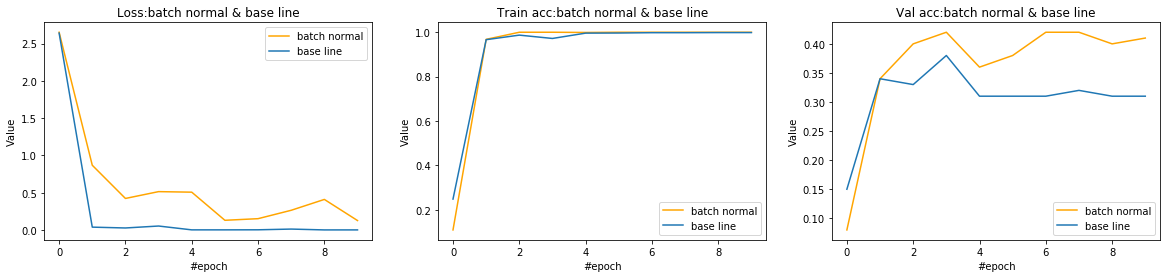

In [49]:
plot_(costs_bn=loss_trains_bn,
      costs=loss_trains,
      cache_acc_train_bn=acc_trains_bn,
      cache_acc_train=acc_trains,
      cache_acc_val_bn=acc_vals_bn,
      cache_acc_val=acc_vals)

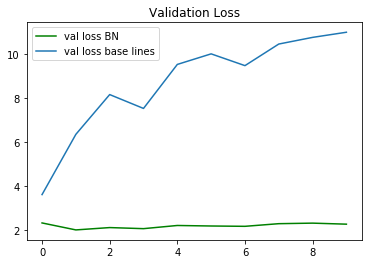

In [55]:
plt.plot(loss_vals_bn,c='green',label="val loss BN")
plt.plot(loss_vals,label="val loss base lines")
plt.title('Validation Loss')
plt.legend()
plt.show()

图中蓝色的线为Base Lines的validation data loss,基本上从一开始,loss就上升,意味着整个模型就开始过拟合,但是在BN中,validation data loss却是一直稳定在一个区间内,虽然没有Regularization/Dropout那么强劲,但是也在一定程度上缓解了过拟合.